<a href="https://colab.research.google.com/github/ThomasZ89/Rent_Pred2/blob/master/Notebooks/Top_Words_FFM_RENT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [ ]:
#!pip install lime

In [2]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import feature_extraction, feature_selection, model_selection, naive_bayes, pipeline, manifold, preprocessing, metrics
import gensim
import gensim.downloader as gensim_api
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split, cross_val_score



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [3]:
# Load large german language model
import spacy.cli
spacy.cli.download("de_core_news_sm")
import de_core_news_sm
nlp = de_core_news_sm.load(disable=['parser', 'tagger', 'ner'])

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')


In [4]:
german_stop_words = stopwords.words('german')
english_stop_words = stopwords.words('english')
def remove_umlauts(tempVar):
    """
    Replace umlauts for a given text   
    :param word: text as string
    :return: manipulated text as str
    """
    tempVar = tempVar.replace('ä', 'ae')
    tempVar = tempVar.replace('ö', 'oe')
    tempVar = tempVar.replace('ü', 'ue')
    tempVar = tempVar.replace('ä', 'ae')
    tempVar = tempVar.replace('ö', 'oe')
    tempVar = tempVar.replace('ü', 'ue')
    tempVar = tempVar.replace('ß', 'ss')  
    return tempVar

def remove_stopwords(document):
    """
    Removes all stopwords from document.
    :param document: A document containing words.
    :return: The document without the stopwords
    """
    stopwords = german_stop_words
    words = document.split(" ")
    words_without_stopwords = [x for x in words if x not in stopwords]
    document_no_stopwords = ' '.join([str(x) for x in words_without_stopwords])
    return document_no_stopwords

def lemmatize_text(text):
    doc = nlp(text)
    tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
    tokens = [tok for tok in tokens if tok not in german_stop_words]
    tokens = ' '.join(tokens)
    return tokens

In [5]:
import pandas as pd
df = pd.read_csv("/content/gdrive/My Drive/housing_text.csv")
# Remove special characters
df["text"] = df["text"].str.replace('[^\w\s]', '')
# Remove Stopwords
df["text"] =df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (german_stop_words+english_stop_words)]))
# Lemmatize
df["text"] = df["text"].apply(lemmatize_text)
# Remove umlauts
df["text"] = df["text"].apply(remove_umlauts)
# Remove Stopwords again (maybe new ones from lemmatiziation)
df["text"] =df["text"].apply(lambda x: ' '.join([word for word in x.split() if word not in (german_stop_words+english_stop_words)]))

In [6]:
## split dataset
dtf_train, dtf_test = model_selection.train_test_split(df, test_size=0.001)
## get target
y_train = dtf_train["rank"].values
y_test = dtf_test["rank"].values

In [7]:
vectorizer = feature_extraction.text.TfidfVectorizer(max_features=50000, ngram_range=(1,2))

In [8]:
corpus = dtf_train["text"]
vectorizer.fit(corpus)
X_train = vectorizer.transform(corpus)
dic_vocabulary = vectorizer.vocabulary_

In [11]:
dic_vocabulary = vectorizer.vocabulary_
y = dtf_train["rank"]
X_names = vectorizer.get_feature_names()
p_value_limit = 0.97
dtf_features = pd.DataFrame()
for cat in np.unique(y):
    chi2, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = dtf_features.append(pd.DataFrame(
                   {"feature":X_names, "score":1-p, "rank":cat}))
    dtf_features = dtf_features.sort_values(["rank","score"], 
                    ascending=[True,False])
    dtf_features = dtf_features[dtf_features["score"]>p_value_limit]
X_names = dtf_features["feature"].unique().tolist()


for cat in np.unique(y):
   print("# {}:".format(cat))
   print("  . selected features:",
         len(dtf_features[dtf_features["rank"]==cat]))
   print("  . top features:", ",".join(
dtf_features[dtf_features["rank"]==cat]["feature"].values[:150]))
   print(" ")

# 0:
  . selected features: 95
  . top features: wohnheim,studentenwohnheim,einschreiben,lage wohnheim,hochschule,immatrikuliert,raunheim,wohnheims,zimmer studentenwohnheim,hessisch hochschule,hessisch,eingeschrieben,hochbett,innen,wohnheim liegen,bonames mitte,campus,hochschule einschreiben,bonames,studentenwohnheim handeln,fahren meist,wohnheim befinden,direkt campus,hornbach,studentenwerk,befinden studentenwohnheim,eingeschrieben student,meist min,verkehrstechnisch super,partykeller,studentenwohnheims,infos www,musst hessisch,studentenverbindung,studierend,ben,holzhausenstrasse miquel,banane,wohnung,soziale arbeit,katholisch,ev,eisdiele post,studieren,klettenberg,ackermann,gwh,soziale,ackermann de,wg ackermann,wg studentenwohnheim,takt einkaufsmoeglichkeiten,campus westend,mitbewohner innen,fernstudenten,fernstudenten praktikanten,gasthoerer,gasthoerer fernstudenten,anschliessen bahn,hochschule immatrikuliert,flughafen fahren,frankfurt frankfurter,ikea hornbach,ben gurion,gurion,gur

In [12]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [17]:
text = "wohnheim,studentenwohnheim,einschreiben,lage wohnheim,hochschule,immatrikuliert,raunheim,wohnheims,zimmer studentenwohnheim,hessisch hochschule,hessisch,eingeschrieben,hochbett,innen,wohnheim liegen,bonames mitte,campus,hochschule einschreiben,bonames,studentenwohnheim handeln,fahren meist,wohnheim befinden,direkt campus,hornbach,studentenwerk,befinden studentenwohnheim,eingeschrieben student,meist min,verkehrstechnisch super,partykeller,studentenwohnheims,infos www,musst hessisch,studentenverbindung,studierend,ben,holzhausenstrasse miquel,banane,wohnung,soziale arbeit,katholisch,ev,eisdiele post,studieren,klettenberg,ackermann,gwh,soziale,ackermann de,wg ackermann,wg studentenwohnheim,takt einkaufsmoeglichkeiten,campus westend,mitbewohner innen,fernstudenten,fernstudenten praktikanten,gasthoerer,gasthoerer fernstudenten,anschliessen bahn,hochschule immatrikuliert,flughafen fahren,frankfurt frankfurter,ikea hornbach,ben gurion,gurion,gurion ring,zimmer wohnheim,min takt,giessener,studentenwohnheim liegen,flughafen anschliessen,kalbach,super frankfurt,wg eigentlich,frei bett,rassismus,baecker eisdiele,flatrate ebenfalls,kommunikationstechnisch,studentenwerks,susanna klettenberg,raunheim verkehrstechnisch,interesse reine,fitnessraum,bzw fachhochschule,fachhochschule hauptsitz,hauptsitz hessen,ev studentenwohnheime,studentenwohnheime de,www ev,hoechst,rené,sexismus,table,giessener strasse"
# Generate a word cloud image
wordcloud = WordCloud().generate(text)

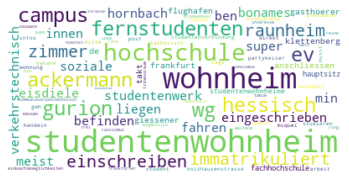

In [18]:
wordcloud = WordCloud(background_color="white").generate(text)
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [19]:
x, y = np.ogrid[:1000, :1000]

mask = (x - 500) ** 2 + (y - 500) ** 2 > 400 ** 2
mask = 255 * mask.astype(int)

wordcloud = WordCloud(background_color="white",width=1920, height=1080, mask=mask).generate(text)


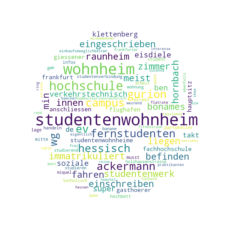

In [20]:
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()